In [1]:
from datasets import load_dataset, concatenate_datasets
import re
from typing import final
import torch
import torchaudio
from collections import defaultdict
from IPython.display import Audio, display
from random import randint
import torch.nn.functional as F
from functools import reduce
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
import pandas as pd
from itertools import combinations
import numpy as np
from functools import partial

In [12]:
def get_metadata(record):
    info     = '\n'.join(record['raw_text'])
    patterns = { 
        'speaker'    : r'Filename:\s*([^/]+)',
        'accent'     : r'Accent:\s*([^\n]+)', 
        'sex'        : r'Gender:\s*([^\n]+)',
        'spoken_text': r'Text:\s*([^\n]+)',
    }
    extract_pattern = lambda pattern: re.search(pattern, info).group(1).strip()
    metadata = { 
        key: extract_pattern(patterns[key]) for key in patterns
    }
    return metadata

def get_audio(record):
    audio = record['audio'].get_all_samples()
    samples = audio.data.mean(0)
    samplerate = audio.sample_rate
    return samples, samplerate

def get_audio_attrs(record):
    metadata            = get_metadata(record)
    dataset, samplerate = get_audio(record)
    return metadata, dataset, samplerate

# ----

def get_audio_groups(metadata, dataset):
    
    key_components = ['accent', 'spoken_text']
    
    audio_groups = defaultdict(list)
    for idx, audio in enumerate(metadata):
        key = tuple(audio[x] for x in key_components)
        audio_groups[key].append(idx)
    
    accents, spoken_texts = map(set, zip(*audio_groups.keys()))
    
    print(f'''
    Original Recordings:
    
    Total Number of Recordings:      {len(cmu)}
    Number of Accents:               {len(accents)}
    Number of Spoken Texts:          {len(spoken_texts)}
    Number of Accented Spoken Texts: {len(audio_groups)}
    ''')

    return audio_groups

# ---

def get_matching_pairs(metadata, dataset, audio_groups):

    pairs = []
    for key in audio_groups:
        audio_group = audio_groups[key]
        n = len(audio_group)
        if n < 2:
            continue
        for i in range(n-1):
            a = audio_group[i]
            for j in range(i+1, n):
                b = audio_group[j]
                t1, t2 = map(lambda idx: dataset[idx].numel(), [a, b])
                dt = abs(t1 - t2) / min(t1, t2)
                similar_tempos = dt < float('0.01')
                having_different_speakers = metadata[a]['speaker'] != metadata[b]['speaker']
                if similar_tempos and having_different_speakers:
                    pairs.append([a, b])
    
    print(f'''
    Different-Speaker, Similar-Tempo, and Same-Accented-Text Recording Pairs:
    
    Total Number of Pairs [Datapoints]: {len(pairs)}
    ''')
    
    return pairs

# ----

def display_pair(dataset, i, j):
    audios = map(lambda idx: Audio(dataset[idx], rate=SAMPLERATE), [i, j])
    for audio in audios:
        display(audio)

def choose_random_pair(pairs):
    return pairs[randint(0, len(pairs))]

def display_random_pair(dataset, pairs):
    pair = choose_random_pair(pairs)
    print(f'\tPair: {pair}\n')
    display_pair(dataset, *pair)
    return pair

# ----

class MFCCTransformer(torchaudio.transforms.MFCC):

    def __init__(self, samplerate, n_mfcc, winlen, hoplen, alpha=None, L=None, N=None, dd=False, rasta=True, postprocess=True):
        super().__init__(
            sample_rate = samplerate,
            n_mfcc = n_mfcc,
            melkwargs = {
                'n_fft': winlen,
                'hop_length': hoplen,
                'n_mels': n_mfcc,
                'center': True,
                'power': 2.0,
            },
        )
        self.alpha       = alpha
        self.L           = L
        self.N           = N
        self.dd          = dd
        self.rasta       = rasta
        self.postprocess = postprocess

    def forward(self, X):
        if self.alpha:
            X = self.pre_emphasis(X, self.alpha)
        MFCC_bt = super().forward(X)
        if self.L:
            MFCC_bt = self.spectral_lifter(MFCC_bt, self.L)
        if self.rasta:
            MFCC_bt = self.temporal_rasta_lifter(MFCC_bt)
        if self.N:
            dMFCC_bt = self.delta(MFCC_bt, self.N)
            MFCC_bt  = torch.concat([MFCC_bt, dMFCC_bt], 1)
            if self.dd:
                ddMFCC_bt = self.delta(dMFCC_bt, self.N)
                MFCC_bt   = torch.concat([MFCC_bt, ddMFCC_bt], 1)
        if self.postprocess:
            MFCC_bt = self.normalize(MFCC_bt, bipolar=False)
            eps     = torch.finfo(MFCC_bt.dtype).eps
            MFCC_bt = torch.log10(MFCC_bt.clamp(eps))
            MFCC_bt = mfcc_transformer.rectify_outliers(MFCC_bt)
        return MFCC_bt
    
    @staticmethod
    def pre_emphasis(X, alpha):
        return X[:,1:] - alpha * X[:,:-1]
    
    @staticmethod
    def spectral_lifter(MFCC_bt, L):
        mel_indices = torch.arange(MFCC_bt.shape[1]).float()
        lifter_win  = 1 + (L / 2.0) * torch.sin(torch.pi * mel_indices / L)
        lifter_win  = lifter_win.view(1,-1,1)
        return lifter_win * MFCC_bt
    
    @staticmethod
    def delta(MFCC_bt, N=2):
        kernel  = torch.arange(-N, N+1, dtype=torch.float32)
        kernel /= torch.square(kernel).sum()
        kernel  = kernel.view(1,1,-1).expand(MFCC_bt.shape[1],-1,-1)
        return F.conv1d(MFCC_bt, kernel, padding=N, groups=MFCC_bt.shape[1])
    
    @staticmethod
    def temporal_rasta_lifter(MFCC_bt):
        b = torch.tensor([0.2,0.1,0.0,-0.1,-0.2])
        a = torch.tensor([1.0,-0.94])
        return __class__.iir(b, a, MFCC_bt)
    
    @staticmethod
    def iir(b, a, X):
        assert a.numel() > 0 and a[0] == 1.0, 'a[0] MUST ALWAYS be 1.0'
        b, a = __class__.pad_iir_coefs(b,a)
        n_taps = a.numel()
        Y = torch.zeros_like(X)
        for idx in range(n_taps-1, 0, -1):
            in_start = n_taps - 1 - idx
            in_end   = -idx
            out_start = in_start + 1
            out_end   = in_end + 1 if in_end < -1 else None
            Y[:,:,out_start:out_end] += b[:,:,idx] * X[:,:,in_start:in_end] - a[:,:,idx] * Y[:,:,in_start:in_end]
        Y += b[:,:,0] * F.pad(X[:,:,n_taps-1:], (n_taps-1, 0))
        return Y
    
    @staticmethod
    def pad_iir_coefs(b, a):
        n_taps = torch.tensor([b.numel(), a.numel()])
        n_pads = n_taps.max() - n_taps
        b, a = torch.stack([
            F.pad(b, (0, n_pads[0])),
            F.pad(a, (0, n_pads[1])),
        ]).reshape(2,1,1,-1)
        return b, a

    @staticmethod
    def rectify_outliers(t):
        t_ = t.detach().clone()
        lo, hi = __class__.compute_whiskers(t_)
        t_[t_ < lo], t_[t_ > hi] = lo, hi
        return t_

    @staticmethod
    def compute_whiskers(t):
        q1, q3 = t.quantile(0.25), t.quantile(0.75)
        iqr    = q3 - q1
        lo, hi = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        return lo, hi

    @staticmethod
    def normalize(X, bipolar=False):
        min_values = X.min(-1).values.min(-1).values.view(-1,1,1)
        max_values = X.max(-1).values.max(-1).values.view(-1,1,1)
        normalized = (X - min_values) / (max_values - min_values)
        if bipolar:
            normalized = 2 * (normalized - 0.5)
        return normalized

# ----

def plot(images, cmap='viridis'):
    if images is None:
        print('Nothing to show.')
        return
    n = len(images)
    if n == 0:
        return
    fig, axs = plt.subplots(n, 1, figsize=(10,5))
    for idx in range(n):
        cax = axs[idx].imshow(images[idx], aspect='auto', origin='lower', cmap=cmap)
        fig.colorbar(cax, ax=axs[idx])
    plt.show()

# ----

class CompositeScaler(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.ab_subsampling_map = self.generate_ab_subsampling_map()
    
    def forward(self, X_ft, scale, a=True):
        scale = round(scale, 2)
        if scale < 0.01 or 0.99 < scale:
            raise ValueError(f'`scale` MUST ALWAYS be a positive value whose range is [0.01, 0.99].')
        if scale in self.ab_subsampling_map.index:
            if not a:
                X_ft = torch.flipud(X_ft)
            scaled_X_ft = self.subsample_ab(X_ft, *self.ab_subsampling_map.loc[scale])
            if not a:
                X_ft = torch.flipud(X_ft)
                scaled_X_ft = torch.flipud(scaled_X_ft)
            if scaled_X_ft.shape[-1] > 0.10 * X_ft.shape[-1]:
                return scaled_X_ft
        return None
    
    @staticmethod
    def generate_ab_subsampling_map():
    
        records = []
        for stride in range(2, 101):
            records.append(__class__.generate_ab_subsampling_record(stride, True))
            records.append(__class__.generate_ab_subsampling_record(stride, False))
            
        df = pd.DataFrame.from_records(records)
        df = df.sort_values('deviation').groupby(['approx_ratio', 'complement_value']).head(1)
        df = df.drop_duplicates('approx_ratio').sort_values('approx_ratio').reset_index(drop=True)
        df.drop(['approx_ratio', 'deviation'], axis=1, inplace=True)
        
        records = df.to_dict(orient='records')
        pair_records = [
            [x for record in record_pair for x in record.values()] \
            for record_pair in combinations(records, 2)
        ]
        records = [list(record.values()) + [1, True, 1.0] for record in records]
        pair_records = records + pair_records
        
        columns = [f'{col}_{x}' for x in 'ab' for col in df.columns]
        df = pd.DataFrame(pair_records, columns=columns)
        
        df['ratio'] = df['ratio_a'] / df['ratio_b']
        
        df['approx_ratio'] = df['ratio'].round(2)
        df = df.sort_values(['ratio_a', 'ratio_b'], ascending=False).groupby('approx_ratio').head(1)
        df = df.drop_duplicates('approx_ratio').sort_values('approx_ratio')
        df.drop(['ratio'], axis=1, inplace=True)
        mask = (df['approx_ratio'] < 0.005) | (df['approx_ratio'] > 0.995)
        df = df[~mask].reset_index(drop=True)
        
        df['scale_factor_a'] = df['approx_ratio'].copy()
        gt_mask_a = df['ratio_a'] > df['ratio_b']
        df.loc[gt_mask_a, 'scale_factor_a'] = round(1 / df.loc[gt_mask_a, 'approx_ratio'], 2)
        
        df['scale_factor_b'] = df['approx_ratio'].copy()
        gt_mask_b = df['ratio_b'] > df['ratio_a']
        df.loc[gt_mask_b, 'scale_factor_b'] = round(1 / df.loc[gt_mask_b, 'approx_ratio'], 2)
        
        df.drop(['ratio_a', 'ratio_b', 'approx_ratio'], axis=1, inplace=True)
        
        assert all(df['scale_factor_a'] < df['scale_factor_b']), 'Scale A should be normalized to always result in shrinking A [0.01 to 0.99] (i.e. Stretching B)'
        
        df.drop('scale_factor_b', axis=1, inplace=True)
        df.set_index('scale_factor_a', inplace=True)

        return df
    
    @staticmethod
    def generate_ab_subsampling_record(stride:int, complement_value:bool):
        ratio = 1 / stride
        if not complement_value:
            ratio = 1 - ratio
        approx_ratio = round(ratio, 2)
        return {
            'stride': stride,
            'complement_value': complement_value,
            'ratio': ratio,
            'approx_ratio': approx_ratio,
            'deviation': abs(ratio - approx_ratio),
        }
    
    @staticmethod
    def subsample_ab(X_ft, stride_a, complement_value_a, stride_b, complement_value_b):
        if X_ft.shape[0] != 2 or X_ft.ndim != 3:
            raise ValueError(f'`X_ft` MUST ALWAYS be a 3D tensor with its first dimension being of size 2.')

        f_bins, t_bins = X_ft.shape[1:]
        
        masks = torch.stack([
            __class__.make_subsampling_mask(f_bins, t_bins, complement_value_a, stride_a), 
            __class__.make_subsampling_mask(f_bins, t_bins, complement_value_b, stride_b),
        ])
        
        t_lengths = masks[:,0,:].sum(-1)
        t_pads    = torch.max(t_lengths) - t_lengths
        
        scaled_X_ft = torch.stack([
            F.pad(
                X_ft[idx, masks[idx]].reshape([f_bins, t_lengths[idx]]),
                pad   = (0, t_pads[idx]),
                value = X_ft[idx].min()
            ) for idx in range(2)
        ])
    
        return scaled_X_ft
    
    @staticmethod
    def make_subsampling_mask(f_bins, t_bins, complement_value, stride):
        blank_tensor = torch.zeros if complement_value else torch.ones
        mask = blank_tensor(f_bins, t_bins, dtype=bool)
        mask[:, ::stride] = bool(complement_value)
        return mask
    
    def transformed_indices(self, i, j, scale, a):
        return self.indices(True, i, j, scale, a)
    
    def original_indices(self, i, j, scale, a):
        return self.indices(False, i, j, scale, a)
    
    def indices(self, fwd, i, j, scale, a):
        record = self.ab_subsampling_record(scale, a)
        if fwd:
            return self.transformed_index(i, *record[:2]), self.transformed_index(j, *record[2:])
        return self.original_index(i, *record[:2]), self.original_index(j, *record[2:])
    
    def ab_subsampling_record(self, scale, a):
        scale = round(scale, 2)
        record = self.ab_subsampling_map.loc[scale].tolist()
        if not a:
            record[:2], record[2:] = record[2:], record[:2]
        return record
    
    @staticmethod
    def original_index(idx, stride, complement_value):
        if complement_value:
            if stride == 1:
                return idx
            return (idx + 1) * stride - 1
        return idx // (stride - 1) * stride + idx % (stride - 1)
    
    @staticmethod
    def transformed_index(idx, stride, complement_value):
        if complement_value:
            if stride == 1:
                return idx
            return (idx + 1) // stride - 1
        return idx // stride * (stride - 1) + idx % stride

# ----

def pair_segmentation(MFCC_bt, t_kernel, t_stride, flattened=True):
    if MFCC_bt.shape[0] != 2 or MFCC_bt.ndim != 3:
        raise ValueError('`MFCC_bt` MUST be a pair of 2D tensors.')
    f_bins, t_bins = MFCC_bt.shape[1:]
    AB = F.unfold(
        MFCC_bt.unsqueeze(1), 
        kernel_size = (f_bins, t_kernel), 
        stride = (f_bins, t_stride),
    ).transpose(1,2)
    if not flattened:
        AB = AB.view(2, -1, f_bins, t_kernel)
    return tuple(AB)

def cosine_similarity(MFCC_bt, t_kernel, t_stride):
    A, B = pair_segmentation(MFCC_bt, t_kernel, t_stride)
    S = A @ B.T / (torch.linalg.norm(A) * torch.linalg.norm(B))
    return S

# ----

def similarity_records(scale, a, t_kernel, similarity_matrix, original_t_bins):
    
    scaler = CompositeScaler()
    
    t_bins = similarity_matrix.shape[0]
    similarities = torch.stack([
        torch.arange(t_bins).unsqueeze(-1).expand(-1, t_bins),
        torch.arange(t_bins).unsqueeze(0).expand(t_bins, -1),
        similarity_matrix,
    ])
    
    original_is, original_js = scaler.original_indices(*similarities[:2], scale, a)
    mask = (original_is < original_t_bins) & \
           (original_js < original_t_bins)
    
    similarities = similarities[:, mask]
    n = mask.sum()
    
    similarities = torch.concat([
        torch.stack([
            torch.tensor([scale] * n),
            torch.tensor([a] * n),
            torch.tensor([t_kernel] * n),
            torch.abs(similarities[0] - similarities[1]),
        ]),
        similarities,
    ]).T
    
    similarities = pd.DataFrame(similarities, columns=['scale', 'a', 't_kernel', 'delta', 'i', 'j', 'similarity'])
    
    int_columns = similarities.columns[1:-1]
    dtype_dict = dict(zip(int_columns, [int] * len(int_columns)))
    similarities = similarities.astype(dtype_dict)
    
    return similarities


def matching_frames(MFCC_bt, scale_range, t_kernel=20, t_stride=1):
    
    scaler, all_records = CompositeScaler(), pd.DataFrame()
    original_t_bins = MFCC_bt.shape[-1]

    for scale in scale_range:
        for a in range(2):
            
            scaled_MFCC_bt = scaler(MFCC_bt, scale, a)
            if (scaled_MFCC_bt is None) or (t_kernel >= scaled_MFCC_bt.shape[-1]):
                continue
            
            similarity_matrix = cosine_similarity(scaled_MFCC_bt, t_kernel, t_stride)
            records = similarity_records(
                scale, a, t_kernel,
                similarity_matrix,
                original_t_bins,
            )
            
            all_records = pd.concat([all_records, records])
    
    return all_records.sort_values(by=['similarity', 'delta', 'scale'], ascending=[False, True, False])

In [3]:
cmu = load_dataset('CLAPv2/CMU_Arctic')
cmu = concatenate_datasets([*cmu.values()])

metadata, dataset, samplerates = zip(*map(get_audio_attrs, cmu))

# ----

def compute_PdB_t(A_ft):
    assert 1 < A_ft.ndim < 4, '`A_ft` MUST be 2D in case it does not have a batch dimension.'
    f_axis = 0 if A_ft.ndim < 3 else 1
    return 10 * torch.log10(torch.square(A_ft).sum(f_axis) + 1e-6)

def apply_vad(Spectrogram, InvSpectrogram, samples, dB_thd=-3):
    X_ft         = Spectrogram(samples)
    A_ft, phi_ft = map(lambda func: func(X_ft), [torch.abs, torch.angle])
    PdB_t        = compute_PdB_t(A_ft)
    f_bins       = A_ft.shape[0]
    vad_ft       = (PdB_t >= dB_thd).unsqueeze(0).expand(f_bins, -1)
    A_ft, phi_ft = map(lambda M_ft: M_ft[vad_ft].reshape(f_bins, -1), [A_ft, phi_ft])
    X_ft         = A_ft * torch.exp(1j * phi_ft)
    samples      = InvSpectrogram(X_ft)
    return samples

ms_to_samples = lambda time_ms, samplerate: time_ms * samplerate // 1000

# ----

unique_samplerates = list(set(samplerates))
assert len(unique_samplerates) == 1
SAMPLERATE:final = unique_samplerates[0]
ms_to_samples = partial(ms_to_samples, samplerate=SAMPLERATE)

WIN_MS, HOP_MS   = 15, 5
WIN_LEN, HOP_LEN = map(ms_to_samples, [WIN_MS, HOP_MS])

Spectrogram = torchaudio.transforms.Spectrogram(
    WIN_LEN, WIN_LEN, HOP_LEN, 
    0, torch.hann_window, None,
)

InvSpectrogram = torchaudio.transforms.InverseSpectrogram(
    WIN_LEN, WIN_LEN, HOP_LEN, 
    0, torch.hann_window,
)

apply_vad    = partial(apply_vad, Spectrogram, InvSpectrogram)
# dataset      = tuple(map(apply_vad, dataset))
audio_groups = get_audio_groups(metadata, dataset)
audio_pairs  = get_matching_pairs(metadata, dataset, audio_groups)

Resolving data files:   0%|          | 0/119 [00:00<?, ?it/s]


    Original Recordings:

    Total Number of Recordings:      13192
    Number of Accents:               5
    Number of Spoken Texts:          1248
    Number of Accented Spoken Texts: 5181
    

    Different-Speaker, Similar-Tempo, and Same-Accented-Text Recording Pairs:

    Total Number of Pairs [Datapoints]: 716
    


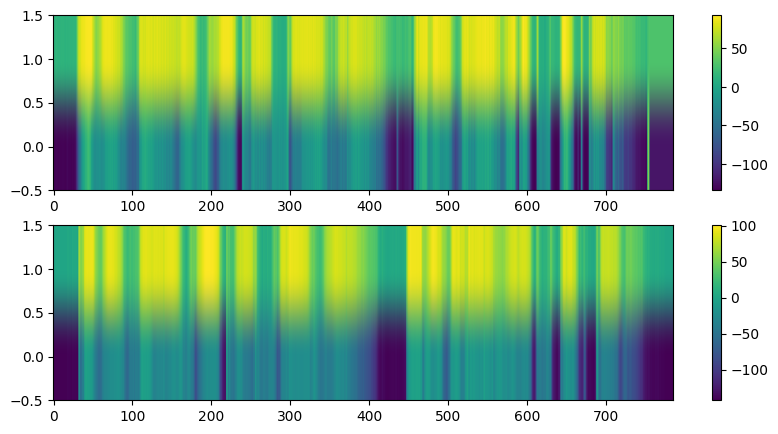

{'scale': 0.5900000000000001, 'a': 1, 't_kernel': 20, 'delta': 25, 'i': 34, 'j': 59, 'similarity': 0.01274022925645113}
-------------------------------------- Best Match --------------------------------------


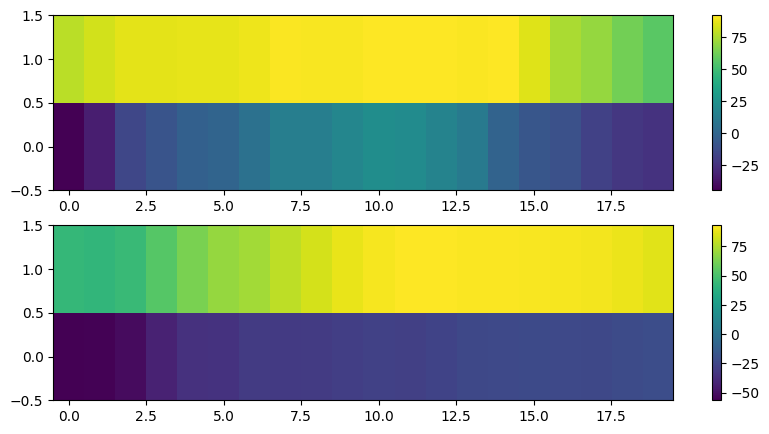

slice(np.int64(594), np.int64(934), None) slice(np.int64(599), np.int64(799), None)


In [21]:
# i, j = display_random_pair(dataset, audio_pairs)
i, j = [3595, 8352]; display_pair(dataset, i, j)

X_t = pad_sequence([dataset[i], dataset[j]], padding_value=dataset[i].min()).T

mfcc_transformer = MFCCTransformer(samplerate  = SAMPLERATE,
                                   n_mfcc      = 13,
                                   winlen      = WIN_LEN,
                                   hoplen      = HOP_LEN,
                                   alpha       = 0.0,
                                   L           = 0,
                                   N           = 0,
                                   dd          = False,
                                   rasta       = False,
                                   postprocess = False)

MFCC_bt = mfcc_transformer(X_t)[:,:2,:]
plot(MFCC_bt, 'viridis')

scaler = CompositeScaler()

SCALE_RANGE = np.arange(0.50, 1.00, 0.01)
T_KERNEL    = 20
T_STRIDE    = 1

matching_records = matching_frames(MFCC_bt, SCALE_RANGE, T_KERNEL, T_STRIDE)

best_record = matching_records.head(1).to_dict('records')[0]
scale, a, t_kernel, _, i, j, _ = best_record.values()

scaled_MFCC_bt = scaler(MFCC_bt, scale, a)
A, B = pair_segmentation(MFCC_bt, t_kernel, t_stride=1, flattened=False)

best_match = torch.stack([A[i], B[j]])

print(best_record)
print('-' * 38 + ' Best Match ' + '-' * 38)
plot(best_match, 'viridis')

original_i0, original_j0 = scaler.original_indices(i, j, scale, a)
original_i1, original_j1 = scaler.original_indices(i + t_kernel, j + t_kernel, scale, a)
island_a, island_b = slice(original_i0, original_i1), slice(original_j0, original_j1)
print(island_a, island_b)

X_ft = Spectrogram(X_t)

samples_a = InvSpectrogram(X_ft[0, :, island_a].unsqueeze(0))
audio_a = Audio(samples_a, rate=SAMPLERATE)
display(audio_a)

samples_b = InvSpectrogram(X_ft[1, :, island_b].unsqueeze(0))
audio_b = Audio(samples_b, rate=SAMPLERATE)
display(audio_b)